In [72]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import DecisionTreeRegressor
spark= SparkSession.builder.appName('Customers').getOrCreate()

In [25]:
from pyspark.ml.regression import LinearRegression


In [26]:
dataset=spark.read.csv("Ecommerce_Customers.csv",inferSchema=True,header=True)

In [30]:
dataset.show()

+--------------------+--------------------+------------------+-----------+---------------+--------------------+-------------------+
|               Email|             Address|Avg Session Length|Time on App|Time on Website|Length of Membership|Yearly Amount Spent|
+--------------------+--------------------+------------------+-----------+---------------+--------------------+-------------------+
|mstephenson@ferna...|835 Frank TunnelW...|       34.49726773|12.65565115|    39.57766802|         4.082620633|         587.951054|
|   hduke@hotmail.com|4547 Archer Commo...|       31.92627203|11.10946073|    37.26895887|         2.664034182|        392.2049334|
|    pallen@yahoo.com|24645 Valerie Uni...|       33.00091476|11.33027806|    37.11059744|         4.104543202|        487.5475049|
|riverarebecca@gma...|1414 David Throug...|       34.30555663|13.71751367|    36.72128268|         3.120178783|         581.852344|
|mstephens@davidso...|14023 Rodriguez P...|       33.33067252|12.79518855|  

In [51]:
dataset.printSchema()

root
 |-- Email: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Avg Session Length: double (nullable = true)
 |-- Time on App: double (nullable = true)
 |-- Time on Website: double (nullable = true)
 |-- Length of Membership: double (nullable = true)
 |-- Yearly Amount Spent: double (nullable = true)



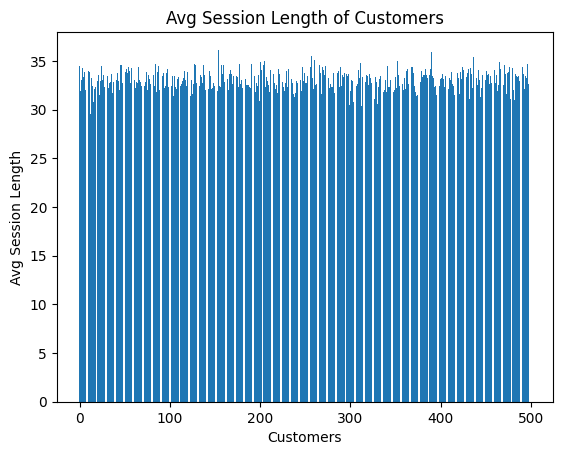

In [31]:
# create a bar graph for Avg Session Length
avg_session_length = dataset.select("Avg Session Length").collect()
x = [i[0] for i in avg_session_length]
y = [i for i in range(len(x))]
plt.bar(y, x)
plt.xlabel("Customers")
plt.ylabel("Avg Session Length")
plt.title("Avg Session Length of Customers")
plt.show()

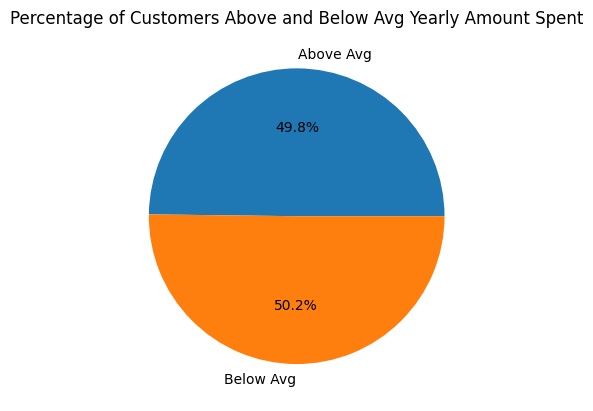

In [33]:
average_spent = dataset.select(avg("Yearly Amount Spent")).collect()[0][0]
above = dataset.filter(dataset["Yearly Amount Spent"] > average_spent).count()
below = dataset.filter(dataset["Yearly Amount Spent"] <= average_spent).count()
labels = ["Above Avg", "Below Avg"]
values = [above, below]
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title("Percentage of Customers Above and Below Avg Yearly Amount Spent")
plt.show()

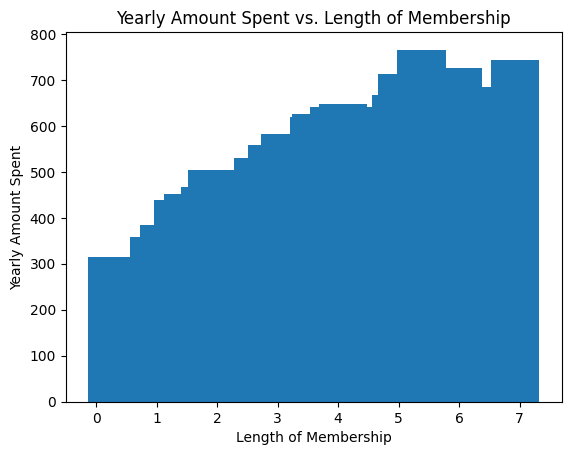

In [34]:
# create a bar graph for Length of Membership vs. Yearly Amount Spent
membership_spent = dataset.select("Length of Membership", "Yearly Amount Spent").orderBy("Length of Membership").collect()
x = [i[0] for i in membership_spent]
y = [i[1] for i in membership_spent]
plt.bar(x, y)
plt.xlabel("Length of Membership")
plt.ylabel("Yearly Amount Spent")
plt.title("Yearly Amount Spent vs. Length of Membership")
plt.show()


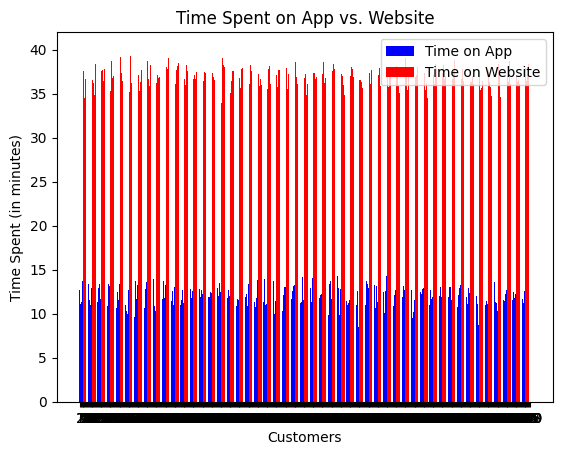

In [35]:
# create a bar graph for Time on App vs. Time on Website
time_spent = dataset.select("Time on App", "Time on Website").collect()
x = [i for i in range(len(time_spent))]
app_time = [i[0] for i in time_spent]
website_time = [i[1] for i in time_spent]
plt.bar(x, app_time, width=0.4, color="blue", label="Time on App")
plt.bar([i + 0.4 for i in x], website_time, width=0.4, color="red", label="Time on Website")
plt.xlabel("Customers")
plt.ylabel("Time Spent (in minutes)")
plt.title("Time Spent on App vs. Website")
plt.xticks([i + 0.2 for i in x], [i + 1 for i in x])
plt.legend(loc="best")
plt.show()


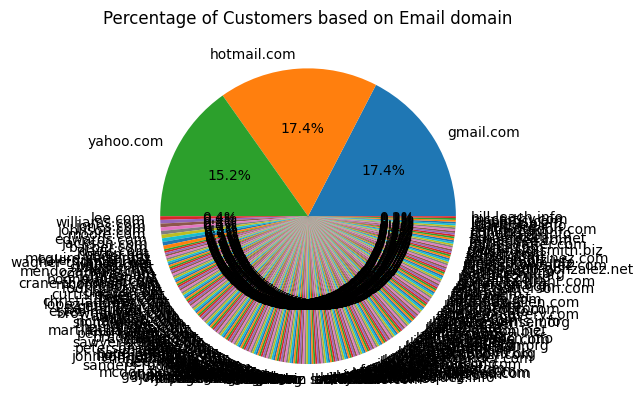

In [38]:
# create a pie chart for the percentage of customers based on email domain
email_domains = dataset.select(split("Email", "@").getItem(1).alias("domain")).groupBy("domain").count().orderBy(desc("count")).collect()
labels = [i["domain"] for i in email_domains]
values = [i["count"] for i in email_domains]
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title("Percentage of Customers based on Email domain")
plt.show()


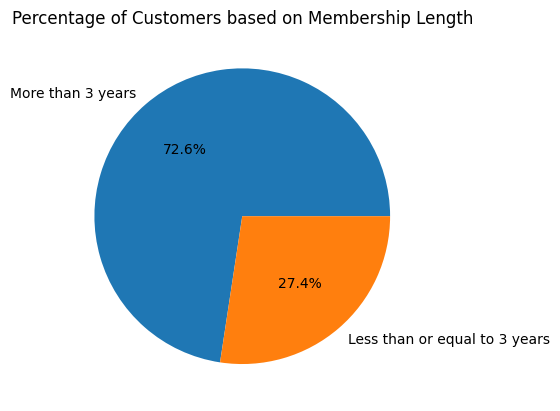

In [46]:
# create a pie chart for the percentage of customers based on membership length
membership_lengths = dataset.select(when(col("Length of Membership") > 3, "More than 3 years").otherwise("Less than or equal to 3 years").alias("membership_length")).groupBy("membership_length").count().orderBy(desc("count")).collect()
labels = [i["membership_length"] for i in membership_lengths]
values = [i["count"] for i in membership_lengths]
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title("Percentage of Customers based on Membership Length")
plt.show()


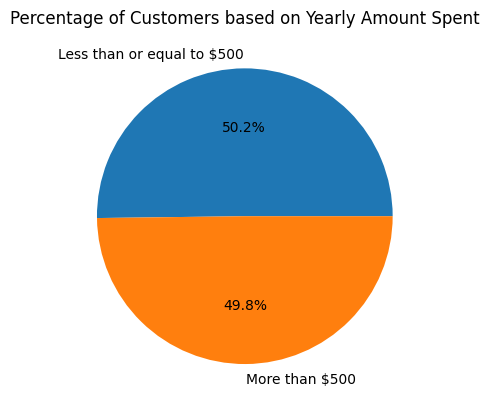

In [47]:
# create a pie chart for the percentage of customers based on yearly amount spent
amount_spent = dataset.select(when(col("Yearly Amount Spent") > 500, "More than $500").otherwise("Less than or equal to $500").alias("amount_spent")).groupBy("amount_spent").count().orderBy(desc("count")).collect()
labels = [i["amount_spent"] for i in amount_spent]
values = [i["count"] for i in amount_spent]
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title("Percentage of Customers based on Yearly Amount Spent")
plt.show()


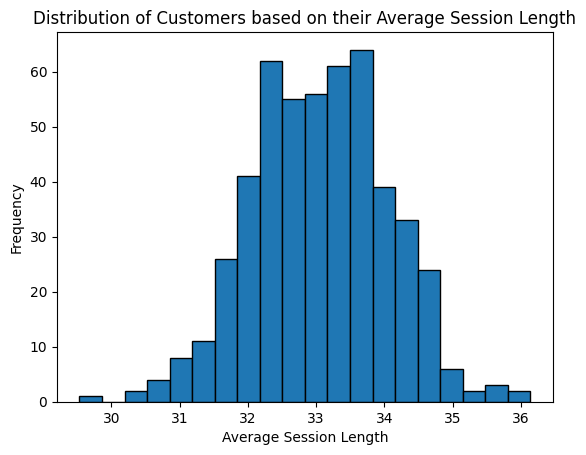

In [49]:
# create a histogram for the distribution of customers based on their average session length
avg_session_length = dataset.select("Avg Session Length").rdd.flatMap(lambda x: x).histogram(20)
bins = avg_session_length[0]
freq = avg_session_length[1]
plt.hist(bins[:-1], bins=bins, weights=freq, edgecolor='black')
plt.title("Distribution of Customers based on their Average Session Length")
plt.xlabel("Average Session Length")
plt.ylabel("Frequency")
plt.show()


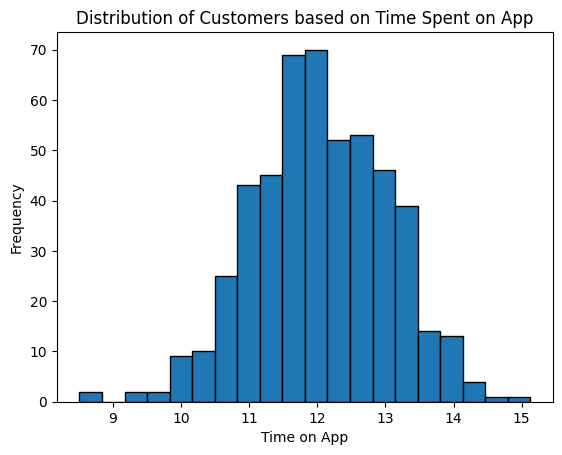

In [50]:
# create a histogram for the distribution of customers based on time spent on app
time_on_app = dataset.select("Time on App").rdd.flatMap(lambda x: x).histogram(20)
bins = time_on_app[0]
freq = time_on_app[1]
plt.hist(bins[:-1], bins=bins, weights=freq, edgecolor='black')
plt.title("Distribution of Customers based on Time Spent on App")
plt.xlabel("Time on App")
plt.ylabel("Frequency")
plt.show()


In [8]:
# sklearn

# x1,X2,X3,X4,X5    Y1 ---->model-->prediction

# [X1,X2,X3,X4,X5]  Y1---->model--->prediction

In [9]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [10]:
featureassembler=VectorAssembler(inputCols=["Avg Session Length","Time on App","Time on Website","Length of Membership"],outputCol="Independent Features")

In [11]:
output=featureassembler.transform(dataset)

In [12]:
output.show()

+--------------------+--------------------+------------------+-----------+---------------+--------------------+-------------------+--------------------+
|               Email|             Address|Avg Session Length|Time on App|Time on Website|Length of Membership|Yearly Amount Spent|Independent Features|
+--------------------+--------------------+------------------+-----------+---------------+--------------------+-------------------+--------------------+
|mstephenson@ferna...|835 Frank TunnelW...|       34.49726773|12.65565115|    39.57766802|         4.082620633|         587.951054|[34.49726773,12.6...|
|   hduke@hotmail.com|4547 Archer Commo...|       31.92627203|11.10946073|    37.26895887|         2.664034182|        392.2049334|[31.92627203,11.1...|
|    pallen@yahoo.com|24645 Valerie Uni...|       33.00091476|11.33027806|    37.11059744|         4.104543202|        487.5475049|[33.00091476,11.3...|
|riverarebecca@gma...|1414 David Throug...|       34.30555663|13.71751367|    36.7

In [13]:
output.select("Independent Features").show()

+--------------------+
|Independent Features|
+--------------------+
|[34.49726773,12.6...|
|[31.92627203,11.1...|
|[33.00091476,11.3...|
|[34.30555663,13.7...|
|[33.33067252,12.7...|
|[33.87103788,12.0...|
|[32.0215955,11.36...|
|[32.73914294,12.3...|
|[33.9877729,13.38...|
|[31.93654862,11.8...|
|[33.99257277,13.3...|
|[33.87936082,11.5...|
|[29.53242897,10.9...|
|[33.19033404,12.9...|
|[32.38797585,13.1...|
|[30.73772037,12.6...|
|[32.1253869,11.73...|
|[32.33889932,12.0...|
|[32.18781205,14.7...|
|[32.61785606,13.9...|
+--------------------+
only showing top 20 rows



In [14]:
output.columns

['Email',
 'Address',
 'Avg Session Length',
 'Time on App',
 'Time on Website',
 'Length of Membership',
 'Yearly Amount Spent',
 'Independent Features']

In [15]:
finalized_data=output.select("Independent Features","Yearly Amount Spent")

In [16]:
finalized_data.show()

+--------------------+-------------------+
|Independent Features|Yearly Amount Spent|
+--------------------+-------------------+
|[34.49726773,12.6...|         587.951054|
|[31.92627203,11.1...|        392.2049334|
|[33.00091476,11.3...|        487.5475049|
|[34.30555663,13.7...|         581.852344|
|[33.33067252,12.7...|         599.406092|
|[33.87103788,12.0...|        637.1024479|
|[32.0215955,11.36...|        521.5721748|
|[32.73914294,12.3...|        549.9041461|
|[33.9877729,13.38...|         570.200409|
|[31.93654862,11.8...|        427.1993849|
|[33.99257277,13.3...|        492.6060127|
|[33.87936082,11.5...|        522.3374046|
|[29.53242897,10.9...|        408.6403511|
|[33.19033404,12.9...|        573.4158673|
|[32.38797585,13.1...|        470.4527333|
|[30.73772037,12.6...|        461.7807422|
|[32.1253869,11.73...|        457.8476959|
|[32.33889932,12.0...|        407.7045475|
|[32.18781205,14.7...|        452.3156755|
|[32.61785606,13.9...|        605.0610388|
+----------

In [62]:
train_data,test_data=finalized_data.randomSplit([0.75,0.25])

In [63]:
regressor=LinearRegression(featuresCol='Independent Features', labelCol='Yearly Amount Spent')
regressor=regressor.fit(train_data)

23/04/25 23:46:21 WARN Instrumentation: [34d5c0f1] regParam is zero, which might cause numerical instability and overfitting.


In [64]:
regressor.coefficients

DenseVector([25.875, 38.5162, 0.5633, 61.42])

In [65]:
regressor.intercept

-1058.236975411029

In [66]:
lr_predictions = regressor.transform(test_data)
evaluator = RegressionEvaluator(labelCol="Yearly Amount Spent", predictionCol="prediction", metricName="rmse")
lr_rmse = evaluator.evaluate(lr_predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % lr_rmse)


Root Mean Squared Error (RMSE) on test data = 11.508


In [67]:
lr_pred_2 = regressor.evaluate(test_data)
lr_pred_2.predictions.show(40)

+--------------------+-------------------+------------------+
|Independent Features|Yearly Amount Spent|        prediction|
+--------------------+-------------------+------------------+
|[30.87948434,13.2...|           490.2066| 493.2897653534137|
|[31.06621816,11.7...|        448.9332932| 461.3657963620158|
|[31.1695068,13.97...|        427.3565308| 416.6576490585203|
|[31.28344748,12.7...|        591.7810894| 568.7429848670972|
|[31.42522688,13.2...|        530.7667187| 534.0739450708841|
|[31.44744649,10.1...|        418.6027421|426.28973620329384|
|[31.5171218,10.74...|        275.9184207| 280.7432735112043|
|[31.52575242,11.3...|        443.9656268| 449.2197047581958|
|[31.57020083,13.3...|        545.9454921| 562.7513445331695|
|[31.57613197,12.5...|         541.226584|  542.576025916022|
|[31.65480968,13.0...|        475.2634237|468.27395945085686|
|[31.72165236,11.7...|        347.7769266| 349.4966821545563|
|[31.76561882,12.4...|        496.5540816|500.90608799340475|
|[31.827

In [68]:
rf = RandomForestRegressor(numTrees=10, maxDepth=5, seed=42,featuresCol='Independent Features',labelCol='Yearly Amount Spent')
rf_model = rf.fit(train_data)

In [69]:
rf_predictions = rf_model.transform(test_data)
rf_rmse = evaluator.evaluate(rf_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rf_rmse)

Root Mean Squared Error (RMSE) on test data = 28.7411


In [92]:
rf_predictions.select("Independent Features","prediction", "Yearly Amount Spent").show()

+--------------------+------------------+-------------------+
|Independent Features|        prediction|Yearly Amount Spent|
+--------------------+------------------+-------------------+
|[30.87948434,13.2...| 502.2065638654376|           490.2066|
|[31.06621816,11.7...| 479.3332984990205|        448.9332932|
|[31.1695068,13.97...|413.62381625512023|        427.3565308|
|[31.28344748,12.7...| 578.4885431104882|        591.7810894|
|[31.42522688,13.2...| 561.2590434749013|        530.7667187|
|[31.44744649,10.1...| 491.7689884452617|        418.6027421|
|[31.5171218,10.74...| 350.4499333394722|        275.9184207|
|[31.52575242,11.3...| 469.5488915545176|        443.9656268|
|[31.57020083,13.3...| 573.9218296708262|        545.9454921|
|[31.57613197,12.5...| 558.1673640530774|         541.226584|
|[31.65480968,13.0...|  478.371333204454|        475.2634237|
|[31.72165236,11.7...| 365.0294350857104|        347.7769266|
|[31.76561882,12.4...| 505.5368553693869|        496.5540816|
|[31.827

In [74]:
dt = DecisionTreeRegressor(featuresCol="Independent Features", labelCol="Yearly Amount Spent", maxDepth=5)
dt_model = dt.fit(train_data)

In [75]:
dt_predictions = dt_model.transform(test_data)
dt_rmse = evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE):", dt_rmse)

Root Mean Squared Error (RMSE): 41.348223427845795


In [91]:
dt_predictions.select("Independent Features","prediction", "Yearly Amount Spent").show()

+--------------------+------------------+-------------------+
|Independent Features|        prediction|Yearly Amount Spent|
+--------------------+------------------+-------------------+
|[30.87948434,13.2...| 489.8264984999999|           490.2066|
|[31.06621816,11.7...|490.94787675106375|        448.9332932|
|[31.1695068,13.97...| 432.5778391666667|        427.3565308|
|[31.28344748,12.7...| 598.1395840166666|        591.7810894|
|[31.42522688,13.2...|      514.71949022|        530.7667187|
|[31.44744649,10.1...|490.94787675106375|        418.6027421|
|[31.5171218,10.74...| 348.0635232714285|        275.9184207|
|[31.52575242,11.3...|490.94787675106375|        443.9656268|
|[31.57020083,13.3...|      514.71949022|        545.9454921|
|[31.57613197,12.5...|      514.71949022|         541.226584|
|[31.65480968,13.0...| 489.8264984999999|        475.2634237|
|[31.72165236,11.7...| 348.0635232714285|        347.7769266|
|[31.76561882,12.4...| 577.7065426886365|        496.5540816|
|[31.827

In [78]:
# Create a table of the RMSE values for each model
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Regression Model", "RMSE"]
table.add_row(["Linear Regression", lr_rmse])
table.add_row(["Random Forest Regression", rf_rmse])
table.add_row(["Decision Tree Regression", dt_rmse])
print(table)

+--------------------------+--------------------+
|     Regression Model     |        RMSE        |
+--------------------------+--------------------+
|    Linear Regression     | 11.507979547938783 |
| Random Forest Regression | 28.74113937454714  |
| Decision Tree Regression | 41.348223427845795 |
+--------------------------+--------------------+


In [87]:
def find_min(lis):
    min = 923109401232141312312
    for i in lis:
        if(i<min): 
            min = i
    return min

rmse_values = [float(lr_rmse), float(rf_rmse), float(dt_rmse)]
model_names = ["Linear Regression", "Random Forest Regression", "Decision Tree Regression"]
best_model = model_names[rmse_values.index(find_min(list(rmse_values)))]


In [88]:
print("The best regression model is:", best_model)


The best regression model is: Linear Regression
